In [5]:
import networkx as nx
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from graph import build_transition_graph, visualise_transition_graph, ZoneTransformer
import pandas as pd
from kloppy import wyscout
from kloppy.domain import Orientation

In [13]:
zt = ZoneTransformer()

match_id = 2058017
data = wyscout.load_open_data(match_id)
home_team, away_team = data.metadata.teams
home_team_id, away_team_id = int(home_team.team_id), int(away_team.team_id)

data = data.transform(
    Orientation.ACTION_EXECUTING_TEAM
) 
df_raw = data.to_df(*zt.INCLUDE_COLS, engine="pandas")
df_raw.set_index("event_id", inplace=True)
df_raw = zt.transform(df_raw)

INCLUDE_EVENTS = ["PASS", "SHOT", "DUEL", "GOALKEEPER"]
df = df_raw[df_raw["event_type"].isin(INCLUDE_EVENTS)]
df_home = df[df["team_id"] == home_team_id]

G_home = build_transition_graph(df_home)

print("Number of nodes:", G_home.number_of_nodes())
print("Number of edges:", G_home.number_of_edges())
print(G_home)

# adj_matrix = nx.to_numpy_array(G_home, weight="weight")
# adj_matrix

Number of nodes: 38
Number of edges: 194
DiGraph with 38 nodes and 194 edges


array([[4., 1., 0., ..., 0., 0., 0.],
       [0., 2., 4., ..., 0., 0., 0.],
       [0., 2., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(38, 38))

### Spectral Clustering of Football Pitch Zones

This method clusters football zones using both **zone interactions** and **node features**. Zones are represented as nodes in a graph, with edges weighted by transition frequency and nodes containing features like event counts, unique players, and role distribution.  

Steps:
1. Extract and normalize node features.  
2. Compute feature similarity using an RBF kernel.  
3. Compute adjacency similarity from the undirected graph.  
4. Combine feature and adjacency similarities with a weighting factor `alpha`.  
5. Apply spectral clustering on the combined similarity matrix.  
6. Assign cluster labels back to the graph nodes.  

Result: clusters group zones with **similar tactical roles** and **connectivity patterns** on the pitch.


In [31]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering

G = G_home  # use the graph built from the match data

# --- Parameters ---
alpha = 0.9  # weight for adjacency vs node features
gamma = 0.5  # RBF kernel gamma for features
k = 5       # number of clusters (tune based on analysis)

# --- 1. Build node feature matrix ---
nodes = list(G.nodes())
node_features = []
for node in nodes:
    f = [
        G.nodes[node]["event_count"],
        G.nodes[node]["unique_players"],
        *G.nodes[node]["role_distribution"],  # flatten role distribution
    ]
    node_features.append(f)

X = np.array(node_features)
X = StandardScaler().fit_transform(X)  # normalize features

# --- 2. Compute feature similarity ---
S_features = rbf_kernel(X, gamma=gamma)

# --- 3. Compute adjacency similarity ---
# Use undirected adjacency for spectral clustering
G_undirected = G.to_undirected()
A = nx.to_numpy_array(G_undirected, nodelist=nodes, weight="weight")

# Optional: normalize adjacency matrix
A_norm = A / (A.max() if A.max() > 0 else 1)

# --- 4. Combine adjacency + feature similarity ---
S_combined = alpha * A_norm + (1 - alpha) * S_features

# --- 5. Spectral clustering ---
sc = SpectralClustering(
    n_clusters=k,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=42
)
labels = sc.fit_predict(S_combined)

# --- 6. Assign cluster labels back to graph nodes ---
for node, label in zip(nodes, labels):
    G.nodes[node]["cluster"] = int(label)

# --- 7. (Optional) Print cluster summary ---
for cluster_id in range(k):
    cluster_nodes = [n for n in nodes if G.nodes[n]["cluster"] == cluster_id]
    print(f"Cluster {cluster_id}: Zones {cluster_nodes}")




Cluster 0: Zones [15, 16, 25, 9, 27, 23, 26, 31, 32, 28, 30]
Cluster 1: Zones [10, 6, 5]
Cluster 2: Zones [2, 8, 36, 34, 37, 35, 3, 0, 33, 38]
Cluster 3: Zones [11, 20, 12, 40, 17, 22, 21, 7]
Cluster 4: Zones [13, 18, 14, 19, 29, 24]


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/2067431411.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", n_clusters)


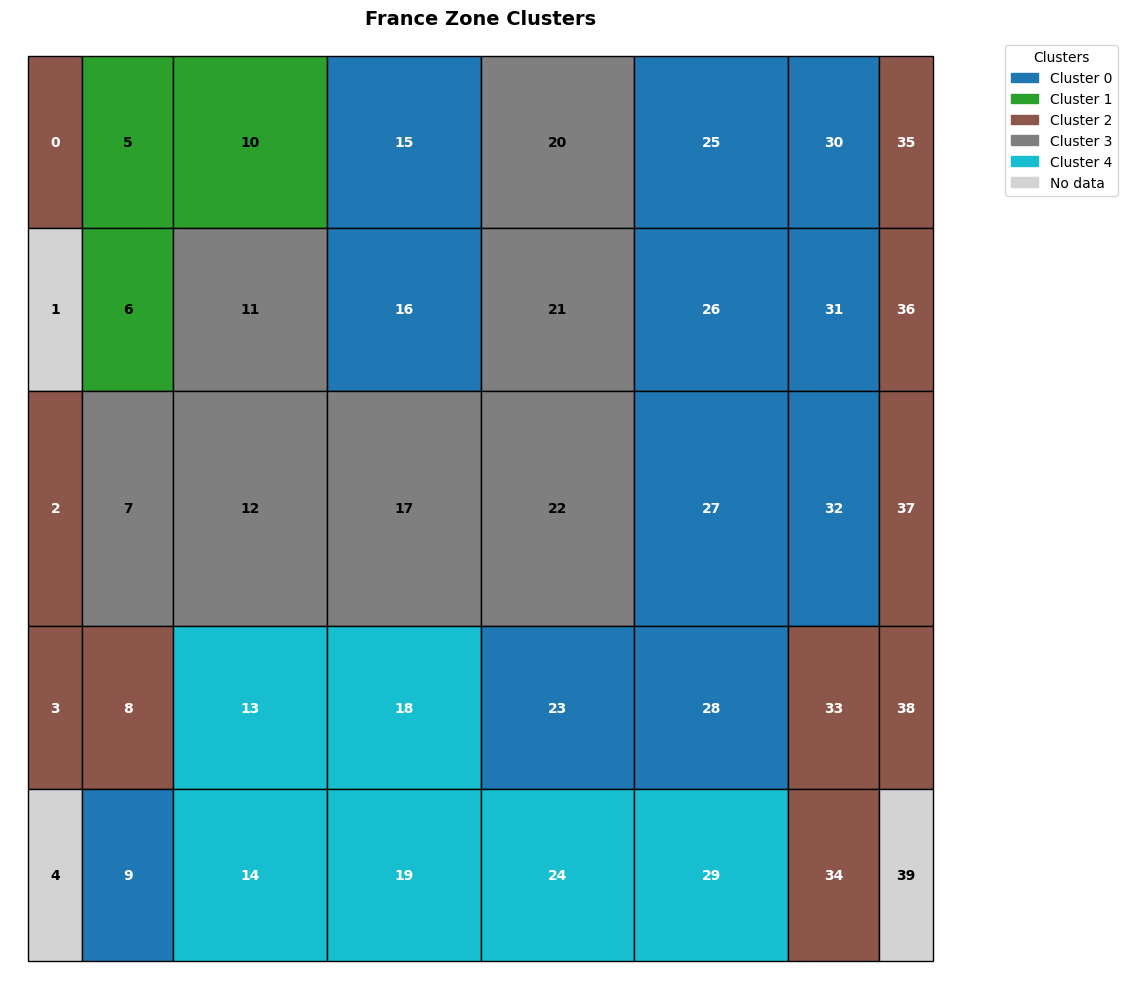

In [32]:
def plot_zone_clusters(discretizer, G, figsize=(14, 10), title="Zone clusters"):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib.cm as cm

    fig, ax = plt.subplots(figsize=figsize)

    zone_ids = list(range(discretizer.n_zones))
    clusters = [G.nodes[z]["cluster"] if z in G.nodes else -1 for z in zone_ids]
    n_clusters = max(clusters) + 1 if clusters else 1
    cmap = cm.get_cmap("tab10", n_clusters)

    for zone_id, cluster in zip(zone_ids, clusters):
        x_min, x_max, y_min, y_max = discretizer.get_zone_bounds(zone_id)
        color = cmap(cluster) if cluster >= 0 else "lightgray"  # missing zones in gray

        # Draw zone
        zone_rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="black",
            facecolor=color,
            zorder=1,
        )
        ax.add_patch(zone_rect)

        x_center, y_center = discretizer.get_zone_center(zone_id)
        ax.text(
            x_center,
            y_center,
            str(zone_id),
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="white" if cluster % 2 == 0 else "black",
        )

    handles = [patches.Patch(color=cmap(i), label=f"Cluster {i}") for i in range(n_clusters)]
    handles.append(patches.Patch(color="lightgray", label="No data"))
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left", title="Clusters")

    ax.set_xlim(-2, 102)
    ax.set_ylim(-2, 102)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.title(title, fontsize=14, fontweight="bold", pad=10)
    plt.tight_layout()

    return fig, ax

fig, ax = plot_zone_clusters(zt, G_home, title=f"{home_team.name} Zone Clusters")
plt.show()

Running spectral clustering with alpha=0.5, gamma=0.1


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


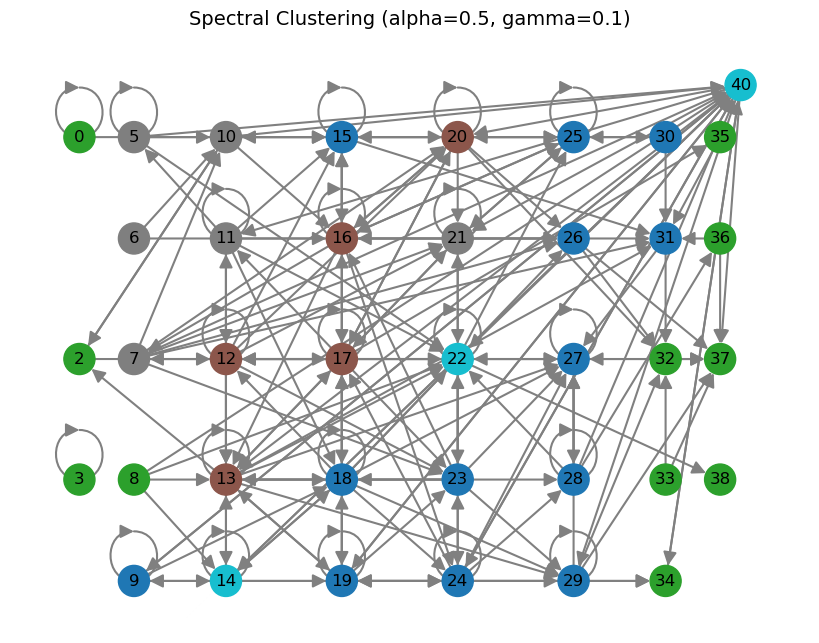

Running spectral clustering with alpha=0.5, gamma=0.5


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


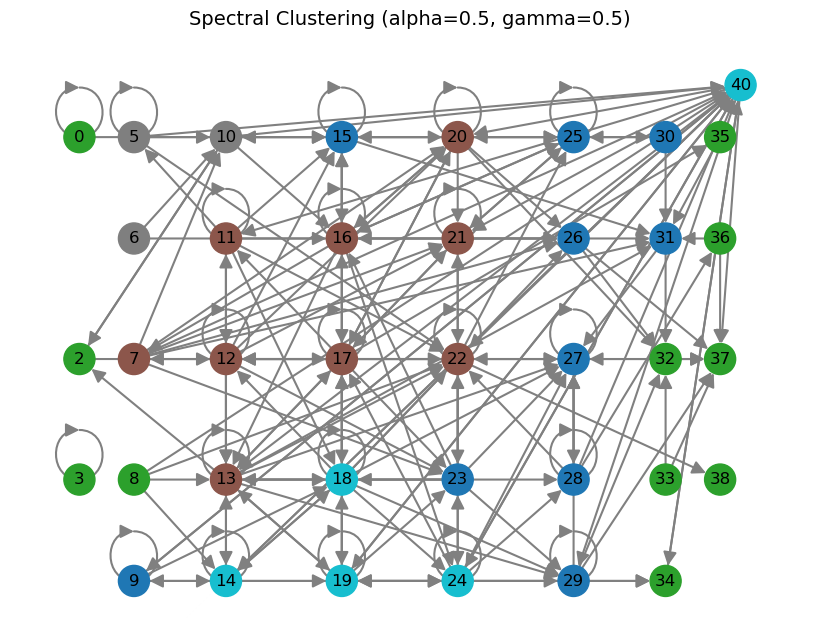

Running spectral clustering with alpha=0.5, gamma=1.0


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


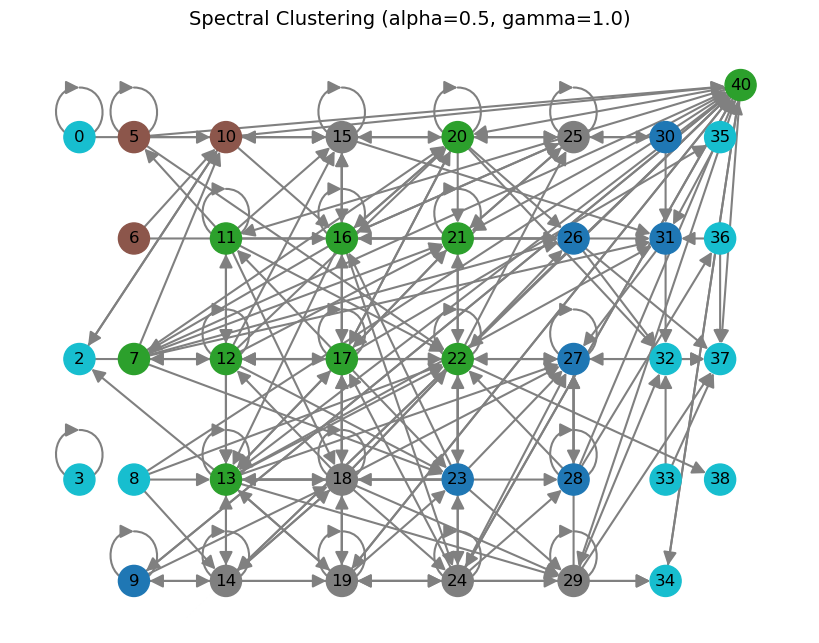

Running spectral clustering with alpha=0.7, gamma=0.1


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


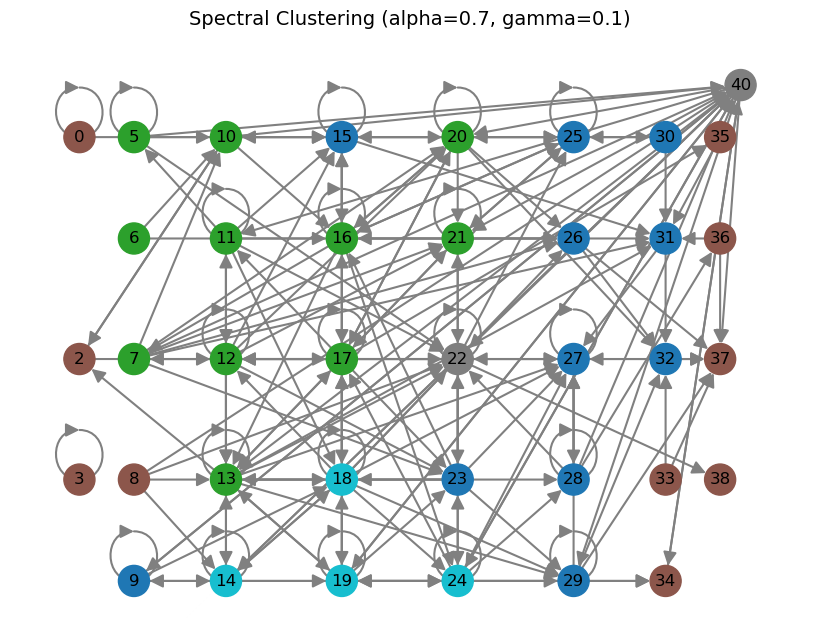

Running spectral clustering with alpha=0.7, gamma=0.5


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


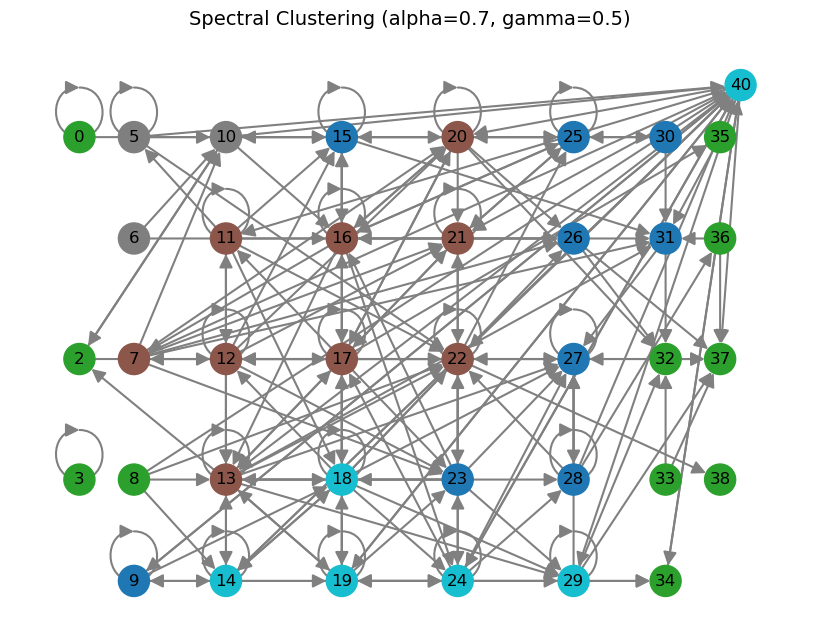

Running spectral clustering with alpha=0.7, gamma=1.0


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


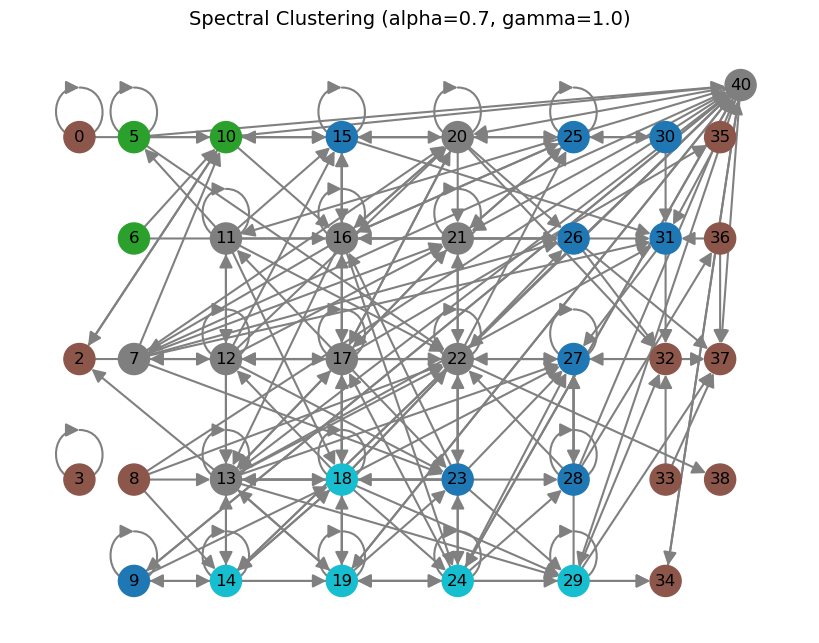

Running spectral clustering with alpha=0.9, gamma=0.1


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


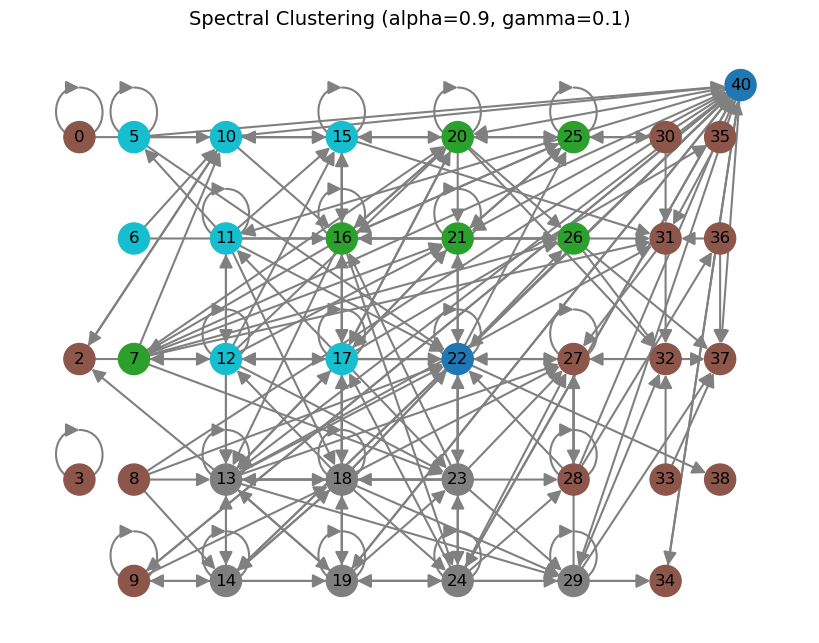

Running spectral clustering with alpha=0.9, gamma=0.5


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


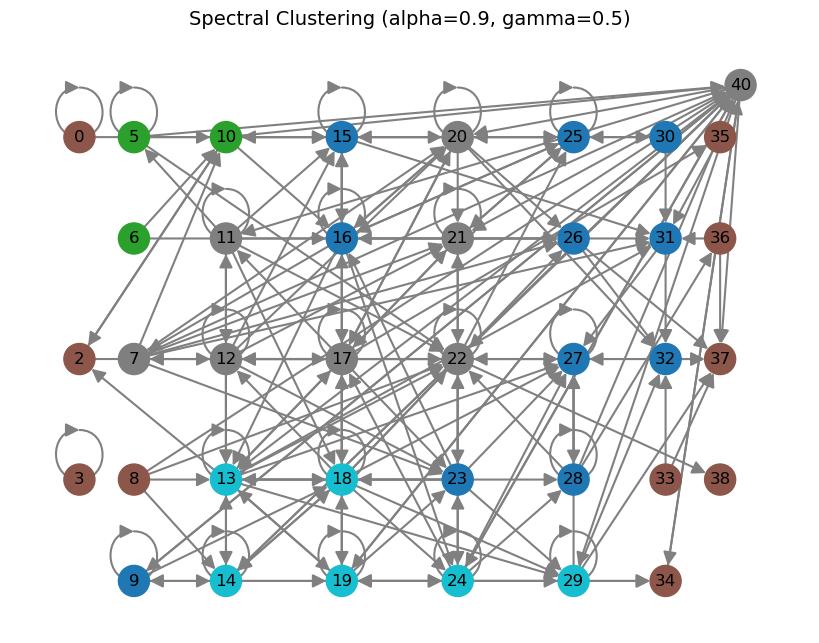

Running spectral clustering with alpha=0.9, gamma=1.0


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/1724358140.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


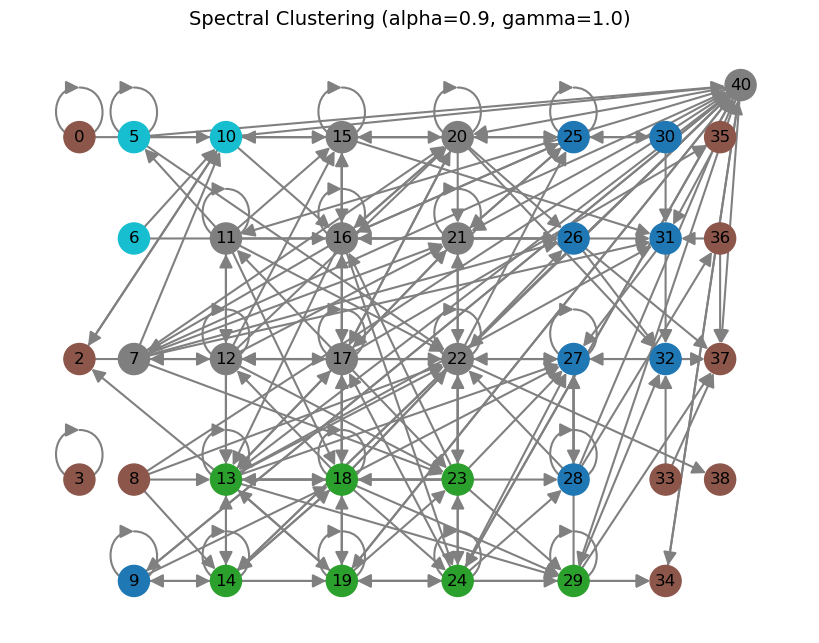

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering

G = G_home  # use the graph built from the match data

# --- Parameters ---
alphas = [0.5, 0.7, 0.9]  # Different weights for adjacency vs node features
gammas = [0.1, 0.5, 1.0]  # Different RBF kernel gamma values
k = 5  # Number of clusters

# --- 1. Build node feature matrix ---
nodes = list(G.nodes())
node_features = []
for node in nodes:
    f = [
        G.nodes[node]["event_count"],
        G.nodes[node]["unique_players"],
        *G.nodes[node]["role_distribution"],  # flatten role distribution
    ]
    node_features.append(f)

X = np.array(node_features)
X = StandardScaler().fit_transform(X)  # normalize features

# --- 2. Loop over alpha and gamma values ---
for alpha in alphas:
    for gamma in gammas:
        print(f"Running spectral clustering with alpha={alpha}, gamma={gamma}")

        # --- 2.1 Compute feature similarity ---
        S_features = rbf_kernel(X, gamma=gamma)

        # --- 2.2 Compute adjacency similarity ---
        G_undirected = G.to_undirected()
        A = nx.to_numpy_array(G_undirected, nodelist=nodes, weight="weight")
        A_norm = A / (A.max() if A.max() > 0 else 1)  # Normalize adjacency matrix

        # --- 2.3 Combine adjacency + feature similarity ---
        S_combined = alpha * A_norm + (1 - alpha) * S_features

        # --- 2.4 Perform spectral clustering ---
        sc = SpectralClustering(
            n_clusters=k,
            affinity="precomputed",
            assign_labels="kmeans",
            random_state=42
        )
        labels = sc.fit_predict(S_combined)

        # --- 2.5 Assign cluster labels back to graph nodes ---
        for node, label in zip(nodes, labels):
            G.nodes[node]["cluster"] = int(label)

        # --- 2.6 Visualize the graph ---
        # Assign colors to nodes based on their cluster
        cluster_colors = plt.cm.get_cmap("tab10", k)
        node_colors = [cluster_colors(G.nodes[node]["cluster"]) for node in G.nodes()]

        # Get positions for the nodes
        pos = {zone_id: zt.get_zone_center(zone_id) for zone_id in G.nodes()}

        # Plot the graph
        plt.figure(figsize=(8, 6))
        nx.draw(
            G,
            pos,
            with_labels=True,
            node_size=500,
            node_color=node_colors,
            arrowsize=20,
            edge_color="gray",
            width=1.5
        )
        plt.title(f"Spectral Clustering (alpha={alpha}, gamma={gamma})", fontsize=14)
        plt.show()

### Clusetring not taking into acount node 40 the outside node 

Running spectral clustering with alpha=0.5, gamma=0.1


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


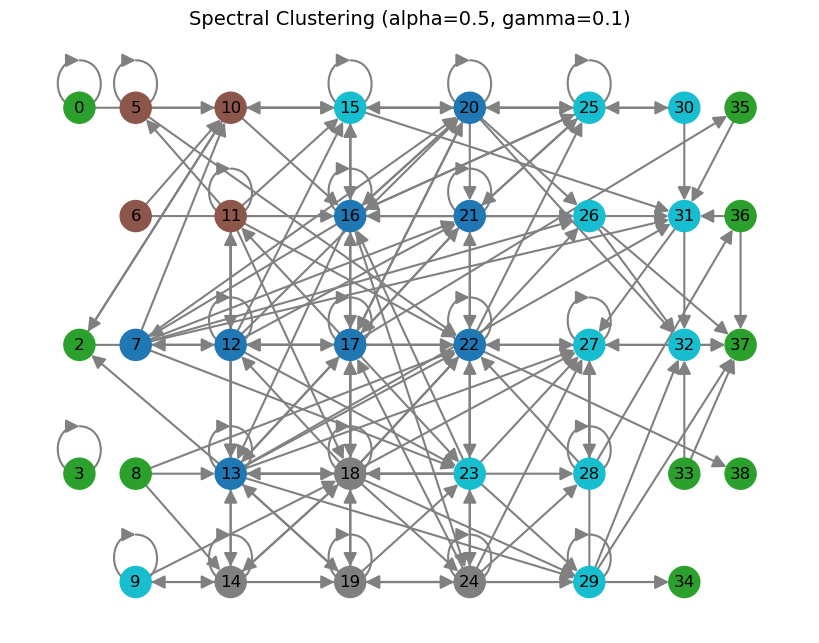

Running spectral clustering with alpha=0.5, gamma=0.5


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


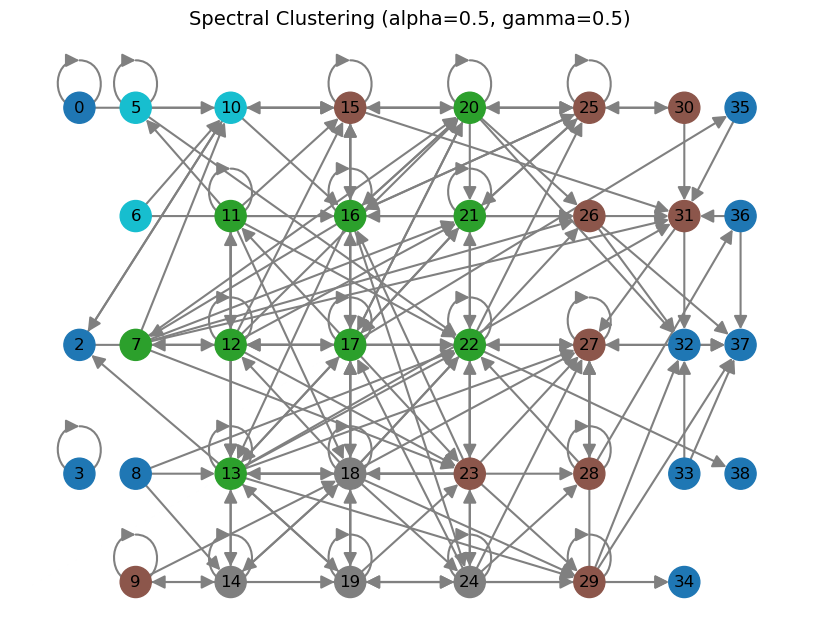

/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


Running spectral clustering with alpha=0.5, gamma=1.0


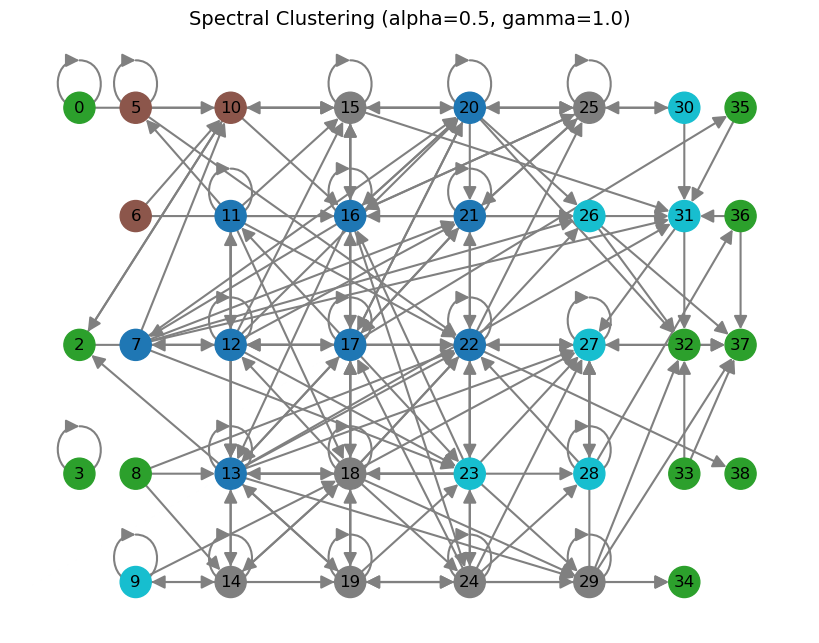

Running spectral clustering with alpha=0.7, gamma=0.1


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


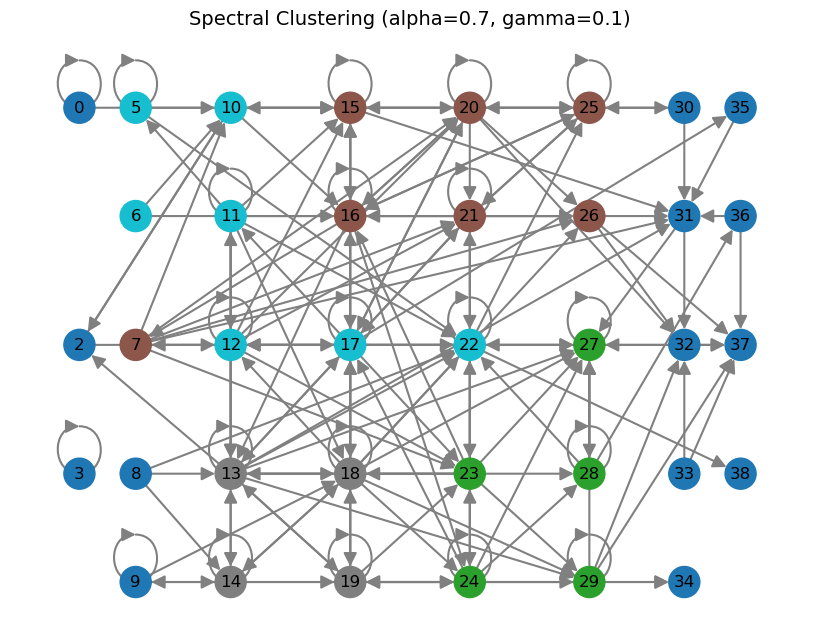

Running spectral clustering with alpha=0.7, gamma=0.5


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


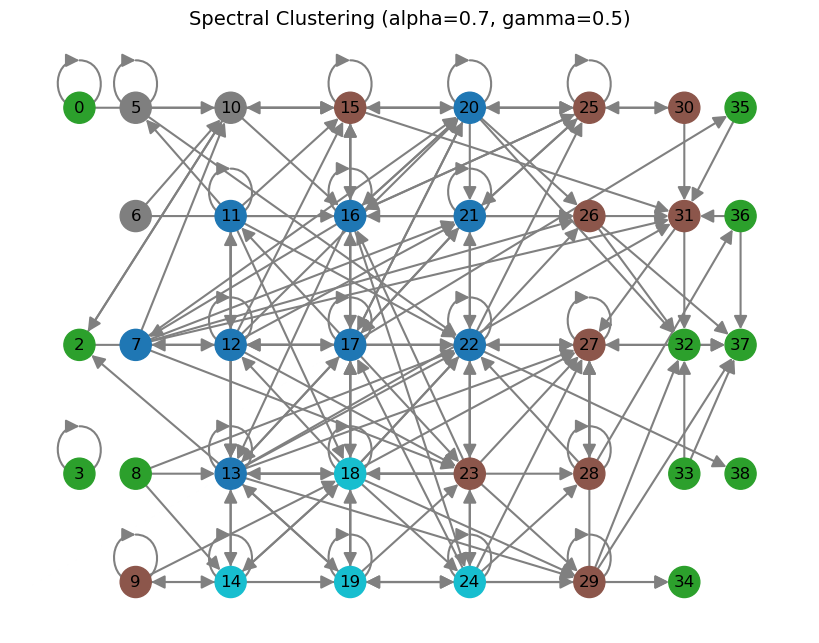

Running spectral clustering with alpha=0.7, gamma=1.0


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


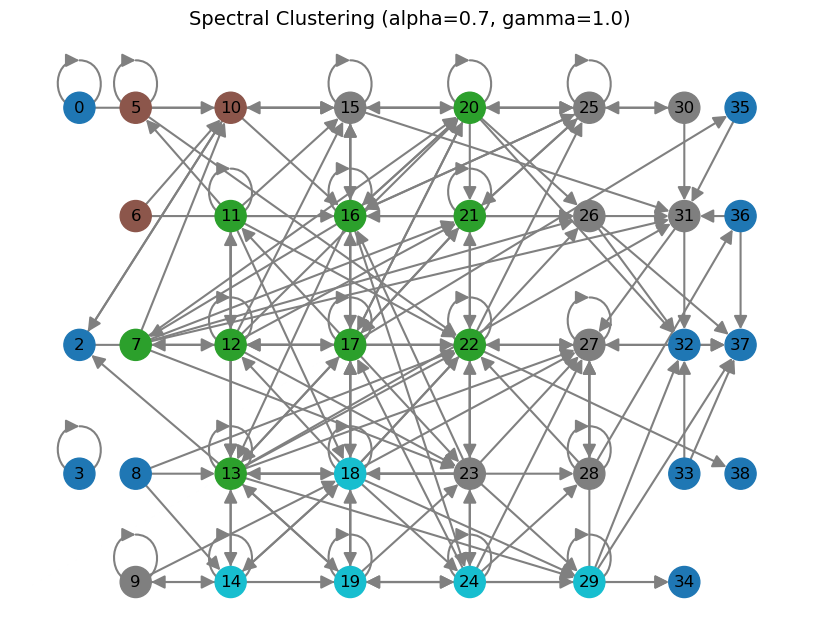

Running spectral clustering with alpha=0.9, gamma=0.1


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


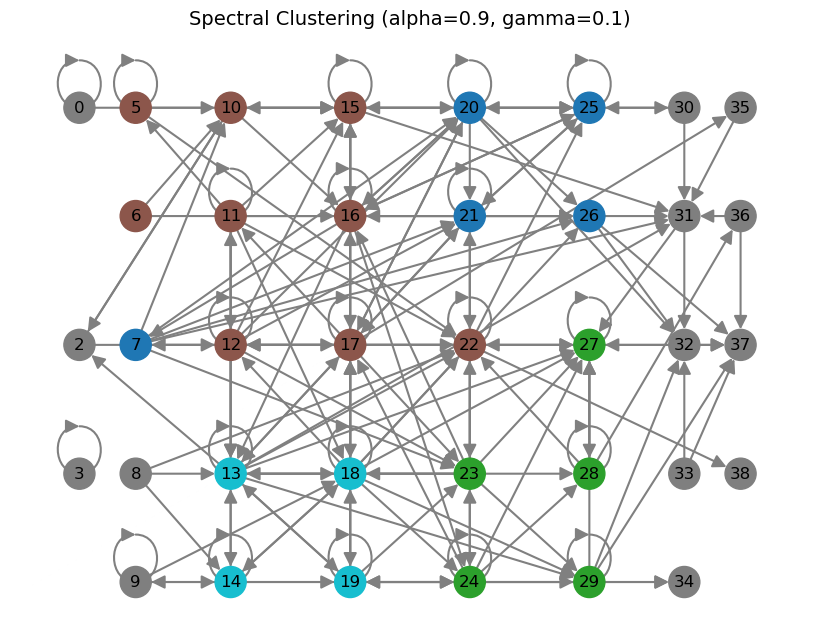

/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


Running spectral clustering with alpha=0.9, gamma=0.5


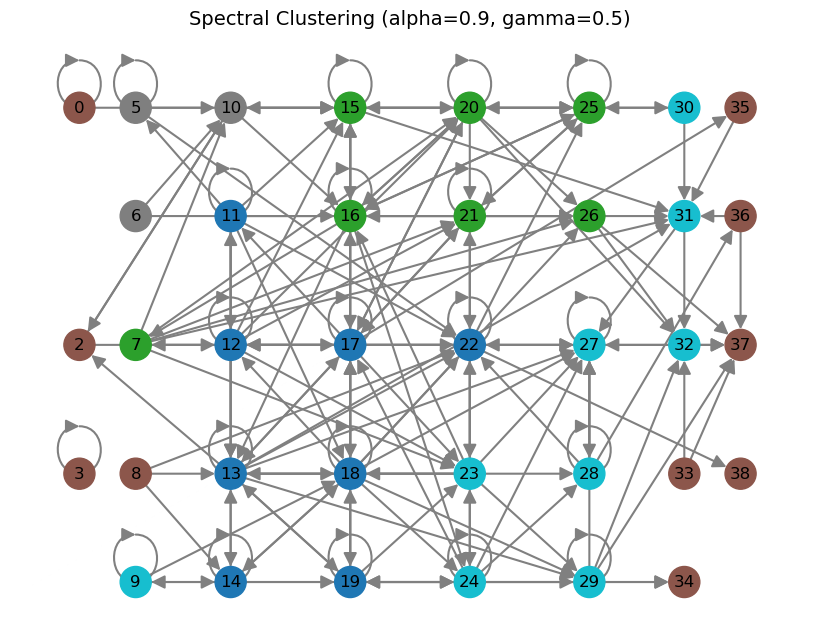

Running spectral clustering with alpha=0.9, gamma=1.0


/var/folders/3g/12kyk7fn4m3b754k_vvbrctc0000gn/T/ipykernel_52929/3471729360.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", k)


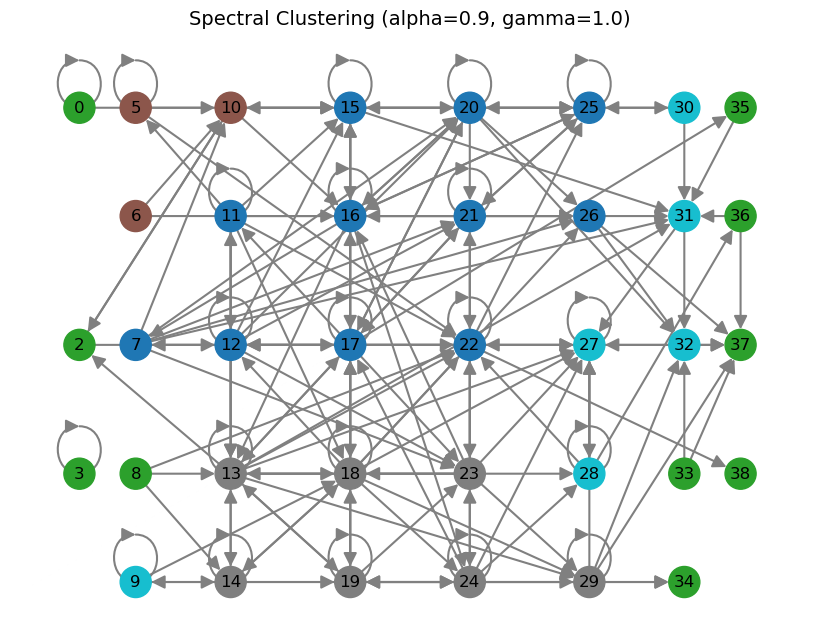

In [34]:
G = G_home  # use the graph built from the match data

# --- Parameters ---
alphas = [0.5, 0.7, 0.9]  # Different weights for adjacency vs node features
gammas = [0.1, 0.5, 1.0]  # Different RBF kernel gamma values
k = 5  # Number of clusters

# --- 1. Filter out node 40 ---
filtered_nodes = [node for node in G.nodes() if node != 40]  # Exclude node 40
G_filtered = G.subgraph(filtered_nodes)  # Create a subgraph with filtered nodes

# --- 2. Build node feature matrix ---
nodes = list(G_filtered.nodes())
node_features = []
for node in nodes:
    f = [
        G_filtered.nodes[node]["event_count"],
        G_filtered.nodes[node]["unique_players"],
        *G_filtered.nodes[node]["role_distribution"],  # flatten role distribution
    ]
    node_features.append(f)

X = np.array(node_features)
X = StandardScaler().fit_transform(X)  # normalize features

# --- 3. Loop over alpha and gamma values ---
for alpha in alphas:
    for gamma in gammas:
        print(f"Running spectral clustering with alpha={alpha}, gamma={gamma}")

        # --- 3.1 Compute feature similarity ---
        S_features = rbf_kernel(X, gamma=gamma)

        # --- 3.2 Compute adjacency similarity ---
        G_undirected = G_filtered.to_undirected()
        A = nx.to_numpy_array(G_undirected, nodelist=nodes, weight="weight")
        A_norm = A / (A.max() if A.max() > 0 else 1)  # Normalize adjacency matrix

        # --- 3.3 Combine adjacency + feature similarity ---
        S_combined = alpha * A_norm + (1 - alpha) * S_features

        # --- 3.4 Perform spectral clustering ---
        sc = SpectralClustering(
            n_clusters=k,
            affinity="precomputed",
            assign_labels="kmeans",
            random_state=42
        )
        labels = sc.fit_predict(S_combined)

        # --- 3.5 Assign cluster labels back to graph nodes ---
        for node, label in zip(nodes, labels):
            G_filtered.nodes[node]["cluster"] = int(label)

        # --- 3.6 Visualize the graph ---
        # Assign colors to nodes based on their cluster
        cluster_colors = plt.cm.get_cmap("tab10", k)
        node_colors = [cluster_colors(G_filtered.nodes[node]["cluster"]) for node in G_filtered.nodes()]

        # Get positions for the nodes
        pos = {zone_id: zt.get_zone_center(zone_id) for zone_id in G_filtered.nodes()}

        # Plot the graph
        plt.figure(figsize=(8, 6))
        nx.draw(
            G_filtered,
            pos,
            with_labels=True,
            node_size=500,
            node_color=node_colors,
            arrowsize=20,
            edge_color="gray",
            width=1.5
        )
        plt.title(f"Spectral Clustering (alpha={alpha}, gamma={gamma})", fontsize=14)
        plt.show()